In [2]:
import pandas as pd
import numpy as np
from scipy import optimize


In [3]:
rawdata=pd.read_csv("2uM_pLipA_40uM_MUB_RUN_0590.csv",header=0,names=("time","fluorescence"))

In [4]:
rawdata

,time,fluorescence
0,0.00010,1.13000
1,0.00015,1.13061
2,0.00020,1.12763
3,0.00025,1.12118
4,0.00030,1.11953
...,...,...
3994,0.19980,1.96380
3995,0.19985,1.96516
3996,0.19990,1.96637
3997,0.19995,1.95806


<AxesSubplot:xlabel='time'>

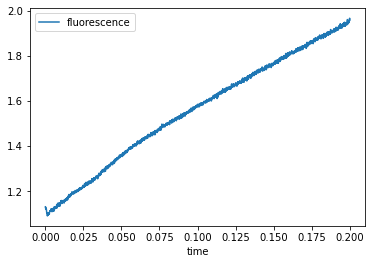

In [5]:
rawdata.plot(x="time",y="fluorescence")

In [6]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x > x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [7]:
x=rawdata.time.to_numpy()
y=rawdata.fluorescence.to_numpy()

In [8]:
p , e = optimize.curve_fit(piecewise_linear, x, y)

### Unsuccessful first attempt

C:\Users\blu002\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [9]:
xd = np.linspace(0, 0.2, 2)

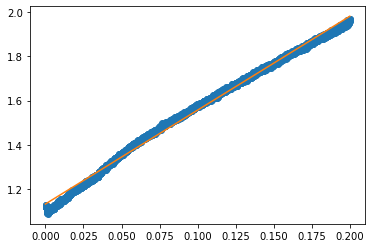

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))

In [11]:
import pwlf
### Following https://stackoverflow.com/a/53641453/16052894

In [12]:
my_pwlf = pwlf.PiecewiseLinFit(x, y)


In [13]:
breaks = my_pwlf.fit(2)
print(breaks)


[1.00000000e-04 7.11621138e-02 2.00000000e-01]


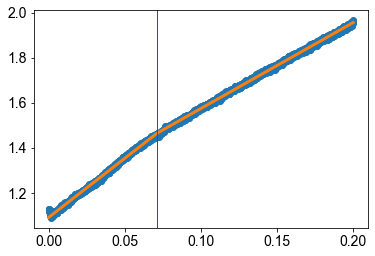

In [16]:
x_hat = np.linspace(x.min(), x.max(), 100)
y_hat = my_pwlf.predict(x_hat)
plt.rcParams['font.size'] = '14'
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.figure()
plt.plot(x, y, 'o')
plt.plot(x_hat, y_hat, '-',linewidth=3.0)
plt.axvline(x=breaks[1],color="green",linewidth=1) #Break in trend
#plt.xlabel("Time(s)")
#plt.ylabel("Fluorescence signal (V)")
plt.savefig("pLipA-stop-flow.png",dpi=300)
plt.show()

In [15]:
from sympy import Symbol
from sympy.utilities import lambdify
xsym = Symbol('x')
### Unmodified from pwlf manual https://jekel.me/piecewise_linear_fit_py/examples.html

def get_symbolic_eqn(pwlf_, segment_number):
    if pwlf_.degree < 1:
        raise ValueError('Degree must be at least 1')
    if segment_number < 1 or segment_number > pwlf_.n_segments:
        raise ValueError('segment_number not possible')
    # assemble degree = 1 first
    for line in range(segment_number):
        if line == 0:
            my_eqn = pwlf_.beta[0] + (pwlf_.beta[1])*(xsym-pwlf_.fit_breaks[0])
        else:
            my_eqn += (pwlf_.beta[line+1])*(xsym-pwlf_.fit_breaks[line])
    # assemble all other degrees
    if pwlf_.degree > 1:
        for k in range(2, pwlf_.degree + 1):
            for line in range(segment_number):
                beta_index = pwlf_.n_segments*(k-1) + line + 1
                my_eqn += (pwlf_.beta[beta_index])*(xsym-pwlf_.fit_breaks[line])**k
    return my_eqn.simplify()


eqn_list = []
f_list = []
for i in range(my_pwlf.n_segments):
    eqn_list.append(get_symbolic_eqn(my_pwlf, i + 1))
    print('Equation number: ', i + 1)
    print(eqn_list[-1])
    f_list.append(lambdify(xsym, eqn_list[-1]))

Equation number:  1
5.24612111586395*x + 1.09181529749831
Equation number:  2
3.81115953723778*x + 1.19393019666097


@Manual{pwlf,
    author = {Jekel, Charles F. and Venter, Gerhard},
    title = {{pwlf:} A Python Library for Fitting 1D Continuous Piecewise Linear Functions},
    year = {2019},
    url = {https://github.com/cjekel/piecewise_linear_fit_py}
}